In [1]:
# from pymongo import MongoClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import Ridge, LogisticRegression
# from sklearn.metrics import r2_score, roc_curve, auc, accuracy_score
import datetime
import time
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier, CatBoostRegressor
%matplotlib inline

In [2]:
trade = pd.read_csv('trade.csv')

In [3]:
trade.head()

,_class,_id,price,quantity,side,symbol,timestamp
0,be.sleepy.component.entity.Trade,178630112,0.111797,0.030,sell,ETHBTC,2018-02-01 23:06:19.924
1,be.sleepy.component.entity.Trade,178630052,0.111810,0.070,buy,ETHBTC,2018-02-01 23:06:17.149
2,be.sleepy.component.entity.Trade,178630046,0.111786,0.031,sell,ETHBTC,2018-02-01 23:06:16.583
3,be.sleepy.component.entity.Trade,178630045,0.111786,0.096,sell,ETHBTC,2018-02-01 23:06:16.583
4,be.sleepy.component.entity.Trade,178630043,0.111786,0.079,sell,ETHBTC,2018-02-01 23:06:16.583


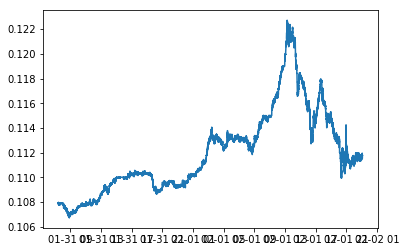

In [4]:
plt.plot(pd.to_datetime(trade['timestamp']), 
         trade['price'].astype(float))

In [5]:
df = pd.read_csv('dataset.csv', index_col=0)

In [6]:
df.head()

,price,ask,bid,high,last,low,open,volume,volumeQuote
timestamp,,,,,,,,,
2018-01-31 07:23:10,0.10783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-31 07:23:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-31 07:23:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-31 07:23:13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-31 07:23:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Using simple moving average to round microchanges in price

In [7]:
df.reset_index(inplace = True)
df['SMA_30'] = df.rolling(60 * 60, min_periods = 1).mean()['price']
df['SMA_60'] = df.rolling(3 * 60 * 60, min_periods = 1).mean()['price']
df.head()

,timestamp,price,ask,bid,high,last,low,open,volume,volumeQuote,SMA_30,SMA_60
0,2018-01-31 07:23:10,0.10783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10783,0.10783
1,2018-01-31 07:23:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10783,0.10783
2,2018-01-31 07:23:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10783,0.10783
3,2018-01-31 07:23:13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10783,0.10783
4,2018-01-31 07:23:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10783,0.10783


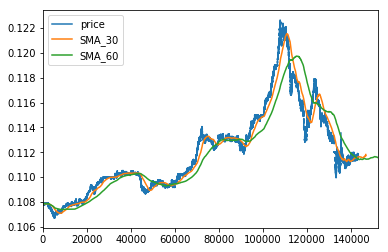

In [8]:
df[['price', 'SMA_30', 'SMA_60']].plot()

Running some tests

In [9]:
class Money:
    btc = 1
    eth = 0
    def buy(self, course):
        if(self.btc > 0):
            self.eth = self.btc * 0.999 / course 
            self.btc = 0
    def sell(self, course):
        if(self.eth > 0):
            self.btc = self.eth * 0.999 * course 
            self.eth = 0

Basically we look at the difference between to SMAs.

If we see that the price will go up, we buy. If we see that the price will go down, we sell.

In [10]:
my_money = Money()
for index, row in df[2 * 60 * 60:].iterrows():
    if((df.loc[index]['SMA_30'] / df.loc[index]['SMA_60'] > 1) &
        (df.loc[index - 1]['SMA_30'] / df.loc[index - 1]['SMA_60'] < 1)):
        btc = my_money.btc  
        my_money.buy(df[index + 1:][df[index + 1:]['price'] > 0].iloc[0]['price'])
        eth = my_money.eth
        df.loc[index, 'react'] = df[index + 1:][df[index + 1:]['price'] > 0].iloc[0]['price']
        print('Buy {} ETH for {} BTH'.format(eth, btc))
    elif((df.loc[index]['SMA_30'] / df.loc[index]['SMA_60'] < 1 ) &
        (df.loc[index - 1]['SMA_30'] / df.loc[index - 1]['SMA_60'] > 1)):
        eth = my_money.eth
        my_money.sell(df[index + 1:][df[index + 1:]['price'] > 0].iloc[0]['price'])
        btc = my_money.btc
        df.loc[index, 'react'] = df[index + 1:][df[index + 1:]['price'] > 0].iloc[0]['price']
        print('Sell {} ETH for {} BTC'.format(eth, btc))
        
print('Final BTC: {}'.format(my_money.btc))
print('Final ETH: {}'.format(my_money.eth))

Buy 9.271519081324557 ETH for 1 BTH
Sell 9.271519081324557 ETH for 1.0186480935241675 BTC
Buy 9.274700790465301 ETH for 1.0186480935241675 BTH
Sell 9.274700790465301 ETH for 1.0129797689580602 BTC
Buy 9.231925897579753 ETH for 1.0129797689580602 BTH
Sell 9.231925897579753 ETH for 1.0380418745947435 BTC
Buy 9.176781436954318 ETH for 1.0380418745947435 BTH
Sell 9.176781436954318 ETH for 1.0306496181872284 BTC
Buy 9.158437050861844 ETH for 1.0306496181872284 BTH
Sell 9.158437050861844 ETH for 1.0285692211875217 BTC
Buy 9.010550494059709 ETH for 1.0285692211875217 BTH
Sell 9.010550494059709 ETH for 1.0658093339380035 BTC
Buy 9.068249904362126 ETH for 1.0658093339380035 BTH
Sell 9.068249904362126 ETH for 1.0385128777312476 BTC
Buy 9.302450212536124 ETH for 1.0385128777312476 BTH
Final BTC: 0
Final ETH: 9.302450212536124


In [11]:
final_btc = my_money.eth *  df[df.price > 0].iloc[-1]['price'] * 0.999
print('In the end we got {}'.format(final_btc))

In the end we got 1.0390668513054004
